# CapsNet on Kuzushiji-MNIST

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
# get the files when running in Colab
!git clone https://github.com/leopoldmaillard/CapsNet_kmnist.git
%cd CapsNet_kmnist/
%mkdir callbacks

Cloning into 'CapsNet_kmnist'...
remote: Enumerating objects: 87, done.
remote: Counting objects: 100% (87/87), done.
remote: Compressing objects: 100% (81/81), done.
remote: Total 87 (delta 43), reused 22 (delta 4), pack-reused 0
Unpacking objects: 100% (87/87), done.
/content/CapsNet_kmnist


### Load & preprocess K-MNIST

In [2]:
X_train = np.load('data/kmnist-train-imgs.npz')['arr_0']
Y_train = np.load('data/kmnist-train-labels.npz')['arr_0']

X_test = np.load('data/kmnist-test-imgs.npz')['arr_0']
Y_test = np.load('data/kmnist-test-labels.npz')['arr_0']

In [3]:
# Preprocess data (input normalization & class matrix output)
X_train = (X_train / 256)[...,None].astype('float32')
Y_train = tf.keras.utils.to_categorical(Y_train, num_classes=10)

X_test = (X_test / 256)[...,None].astype('float32')
Y_test = tf.keras.utils.to_categorical(Y_test, num_classes=10)

### CapsNet model definition

In [4]:
from capsulelayers import CapsuleLayer, PrimaryCap, Length, Mask

In [5]:
# All hyperparameters in a single cell
epochs = 10
batch_size = 100
learning_rate = 0.001
decay = 0.9 # to decrease learning rate at each epoch
lam_recon = 0.392 # decoder loss coefficient
n_routings = 3 # number of routing by agreement iterations
n_class = 10
data_augmentation = False

In [6]:
def CapsNet(input_shape, n_class, routings, batch_size):
    
    # input layer
    x = tf.keras.layers.Input(input_shape, batch_size = batch_size)
    
    # layer 1 : regular Convolutionnal layer
    conv1 = tf.keras.layers.Conv2D(filters = 256, kernel_size = (9,9), activation = 'relu', name = 'conv1')(x)
    
    # layer 2 : PrimaryCaps, which is a convolution layer with Squash activation
    # dim_capsule : corresponds to the dimension of the capsule output vector
    # n_channels : number of capsule types
    primarycaps = PrimaryCap(conv1, dim_capsule = 8, n_channels = 32, kernel_size = 9, strides = 2, padding = 'valid')
    
    # layer 3 : CapsuleLayer (involves routing by agreement)
    # each capsule in this layer represents one of the Kuzushiji symbol
    kcaps = CapsuleLayer(num_capsule = n_class, dim_capsule = 16, routings = routings, name = 'kcaps')(primarycaps)
    
    # layer 4 : layer that takes the length of each capsule
    out_caps = Length(name='capsnet')(kcaps)
    
    # Let's build the decoder network
    # 2 reconstructions are performed :
    # - first one is to reconstruct image according to the true label
    # - second one is to reconstruct image according to the vector with maximal length (prediction)
    y = tf.keras.layers.Input((n_class,))
    masked_by_y = Mask()([kcaps, y])
    masked = Mask()(kcaps)
    
    # Dense layers of the decoder architecture as described in the paper
    decoder = tf.keras.models.Sequential(name = 'decoder')
    decoder.add(tf.keras.layers.Dense(512, activation = 'relu', input_dim = 16 * n_class))
    decoder.add(tf.keras.layers.Dense(1024, activation = 'relu'))
    decoder.add(tf.keras.layers.Dense(input_shape[0]*input_shape[1], activation = 'sigmoid'))
    decoder.add(tf.keras.layers.Reshape(input_shape, name = 'out_recon'))
    
    # Models used for training and evaluation
    # train_model involves training of the decoder
    # while evaluation model, given an input x, outputs his prediction and his reconstruction using the trained decoder
    train_model = tf.keras.models.Model([x, y], [out_caps, decoder(masked_by_y)])
    eval_model = tf.keras.models.Model(x, [out_caps, decoder(masked)])
                
    return train_model, eval_model

In [7]:
# a custom loss is used for training
def margin_loss(y_true, y_pred):
    loss = y_true * tf.square(tf.maximum(0., 0.9 - y_pred)) + \
           0.5 * (1 - y_true) * tf.square(tf.maximum(0., y_pred - 0.1))
    
    return tf.reduce_mean(tf.reduce_sum(loss, 1))

### Data augmentation

In [8]:
# Data augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator 

# https://arxiv.org/abs/1708.04552
def cutout(image):
    size = 6
    h, w = image.shape[0], image.shape[1]
    cut_image = image
    y = np.random.randint(h)
    x = np.random.randint(w)
    y1 = np.clip(y - size // 2, 0, h)
    y2 = np.clip(y + size // 2, 0, h)
    x1 = np.clip(x - size // 2, 0, w)
    x2 = np.clip(x + size // 2, 0, w)
    cut_image[y1:y2,x1:x2,:] = 0
    
    return cut_image

def train_generator(x, y, batch_size):
        train_datagen = ImageDataGenerator(width_shift_range = 0.1,
                                           height_shift_range = 0.1,
                                           preprocessing_function = cutout)
        generator = train_datagen.flow(x, y, batch_size=batch_size)
        while 1:
            x_batch, y_batch = generator.next()
            yield (x_batch, y_batch), (y_batch, x_batch)

### Training

In [33]:
log = tf.keras.callbacks.CSVLogger('callbacks/log.csv')

# weigths of the model that has the best validation accuracy are saved during training
checkpoint = tf.keras.callbacks.ModelCheckpoint('callbacks/weights-{epoch:02d}.h5',
                                                monitor = 'val_capsnet_accuracy', save_best_only=True, 
                                                save_weights_only=True, verbose=1)

# learning rate is reduced during training for optimal gradient descent
lr_decay = tf.keras.callbacks.LearningRateScheduler(lambda epoch : learning_rate * (decay ** epoch))

In [9]:
model, eval_model = CapsNet(input_shape = X_train[0].shape, n_class = n_class, 
                            routings = n_routings, batch_size = batch_size)

In [10]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(100, 28, 28, 1)]   0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (100, 20, 20, 256)   20992       input_1[0][0]                    
__________________________________________________________________________________________________
primarycap_conv2d (Conv2D)      (100, 6, 6, 256)     5308672     conv1[0][0]                      
__________________________________________________________________________________________________
primarycap_reshape (Reshape)    (100, 1152, 8)       0           primarycap_conv2d[0][0]          
______________________________________________________________________________________________

In [36]:
model.compile(optimizer = tf.keras.optimizers.Adam(lr = learning_rate), loss=[margin_loss, 'mse'],
              loss_weights=[1, lam_recon], metrics={'capsnet': 'accuracy'})

In [41]:
if(data_augmentation):
    history = model.fit(train_generator(X_train, Y_train, batch_size),
              steps_per_epoch=int(Y_train.shape[0] / batch_size),
              epochs = epochs,
              validation_data=([X_test, Y_test], [Y_test, X_test]), batch_size = batch_size,
              callbacks = [log, checkpoint, lr_decay])
else :
    history = model.fit([X_train, Y_train], [Y_train, X_train], batch_size = batch_size, epochs = epochs,
                  validation_data=([X_test, Y_test], [Y_test, X_test]), callbacks = [log, checkpoint, lr_decay])

### Training results

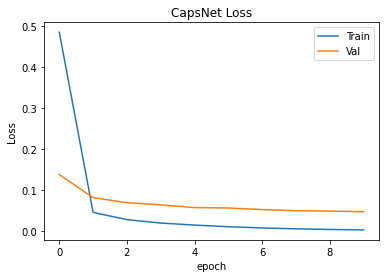

In [20]:
plt.plot(history.history['capsnet_loss'])
plt.plot(history.history['val_capsnet_loss'])
plt.title('CapsNet Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

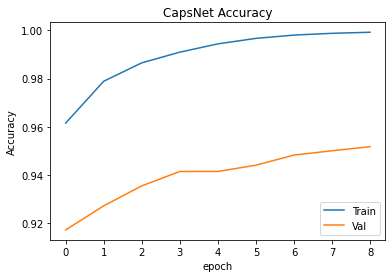

In [25]:
plt.plot(history.history['capsnet_accuracy'][1:])
plt.plot(history.history['val_capsnet_accuracy'][1:])
plt.title('CapsNet Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()

## CapsNet Evaluation & Reconstructions

In [11]:
# Load the model that achieved the best performances on our experiments
model.load_weights('criann_results/03/weights-84.h5')

In [77]:
# Predictions & reconstructions on kmnist training & test set
y_train_pred, X_train_recon = eval_model.predict(X_train, batch_size=100)
y_test_pred, X_test_recon = eval_model.predict(X_test, batch_size=100)

print('Train accuracy : ', np.sum(np.argmax(y_train_pred, axis = 1) == np.argmax(Y_train, axis = 1)) / Y_train.shape[0])
print('Test accuracy : ', np.sum(np.argmax(y_test_pred, axis = 1) == np.argmax(Y_test, axis = 1)) / Y_test.shape[0])

Train accuracy :  0.9999
Test accuracy :  0.9845


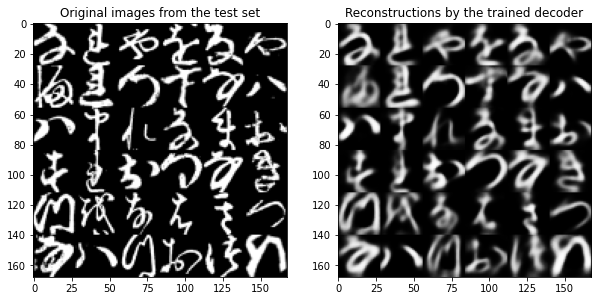

In [87]:
# re-execute this cell to see results with other images
# will plot dim * dim test images, and their associated reconstructions

def visualize_recons(X_ori, X_recon, dim):
    ori = np.empty((28*dim, 28*dim))
    rec = np.empty((28*dim, 28*dim))
    indices = np.random.randint(X_ori.shape[0], size = dim * dim)
    ind = 0

    for i in range(dim):
        for j in range(dim):
            ori[i*28:(i+1)*28, j*28:(j+1)*28] = X_ori[indices[ind]][:,:,0]
            rec[i*28:(i+1)*28, j*28:(j+1)*28] = X_recon[indices[ind]][:,:,0]
            ind+=1
    plt.figure(figsize = (10, 10))
    plt.subplot(1,2,1)
    plt.imshow(ori*255, 'gray')
    plt.title("Original images from the test set")
    plt.subplot(1,2,2)
    plt.imshow(rec*255, 'gray')
    plt.title("Reconstructions by the trained decoder")
    plt.show()
    
visualize_recons(X_train, X_train_recon, 6)